## 0. Objective

In this notebook, we evaluate all the information present in the police reports and try to identify which are the main causes of drivers and vehicle passengers' wounding.

## 1. Import required modules

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

sns.set_style('darkgrid')
sns.set_palette(palette="RdBu")

## 2. Load required data

In [3]:
accidents_drivers_passengers = pd.read_parquet('../00-data/processed/accidents_drivers_passengers.parquet')

## 3. Data preparation for modeling

**`Model data selection`**

* We first selected the features that due to our day to day experience seemed to have more impact on the occurrence and gravity of the accidents;

In [4]:
first_model_columns = ['Lesões a 30 dias', 'Tipo Natureza', 'Estado Conservação', 'Reg Circulação', 'Sinais Luminosos', 
                       'Intersecção Vias', 'Factores Atmosféricos', 'Luminosidade', 'Cond Aderência', 'Categoria Veículos',
                      'Idade', 'Sexo', 'Acessórios', 'Licença Condução', 'Localizações', 'Traçado 1', 'Traçado 2', 'Traçado 3',
                      'Traçado 4']
first_model_data = accidents_drivers_passengers[first_model_columns]

**`Prepare dependent feature`**

We convert this feature to a classification model:
* 0 - Ok
* 1 - Wounded

In [5]:
first_model_data = (
    first_model_data
    .replace({'Lesões a 30 dias': {'Ileso': 0, 
                                   'Ferido leve': 1, 
                                   'Ferido grave': 1, 
                                   'Morto':1}})
)

**`Prepare independent features`**

We convert the independent variables to dummies.

In [6]:
coluna = 'Tipo Natureza'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Colisão'])
)

In [7]:
coluna = 'Estado Conservação'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Em bom estado'])
)

In [8]:
coluna = 'Reg Circulação'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Sentido único'])
)

In [9]:
coluna = 'Sinais Luminosos'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Inexistentes'])
)

In [10]:
coluna = 'Intersecção Vias'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Fora da intersecção'])
)

In [11]:
coluna = 'Factores Atmosféricos'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Bom tempo'])
)

In [12]:
coluna = 'Luminosidade'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Em pleno dia'])
)

In [13]:
coluna = 'Cond Aderência'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Seco e limpo'])
)

In [14]:
coluna = 'Categoria Veículos'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Automóvel ligeiro'])
)

In [15]:
coluna = 'Sexo'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Feminino'])
)

In [16]:
coluna = 'Acessórios'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Seguro'])
)

In [17]:
coluna = 'Licença Condução'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Com carta'])
)

In [18]:
coluna = 'Localizações'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Dentro das localidades'])
)

In [19]:
coluna = 'Traçado 1'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Recta'])
)

In [20]:
coluna = 'Traçado 2'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Em patamar'])
)

In [21]:
coluna = 'Traçado 3'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Berma pavimentada'])
)

In [22]:
coluna = 'Traçado 4'
first_model_data = (
    pd.concat([first_model_data, 
               pd.get_dummies(first_model_data[coluna])], axis=1)
    .drop(columns = [coluna, 'Em plena via'])
)

## 4. Model training and evaluation

**`Divide data in dependent and independet features`**

In [189]:
X = first_model_data.drop(columns = ['Lesões a 30 dias'])
y = first_model_data.copy().pop('Lesões a 30 dias')

**`Scale the data`**

Most of the variables are binary, however, the age data needs to be scaled.

In [190]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=y.index)

**`Train ordinary least squares model with regularization`**

In [234]:
model = sm.OLS(y, X_scaled)
results = model.fit_regularized(alpha = 0.003, refit=True)

**`Evaluate model summary`**

In [235]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:       Lesões a 30 dias   R-squared (uncentered):                   0.640
Model:                            OLS   Adj. R-squared (uncentered):              0.639
Method:                 Least Squares   F-statistic:                              570.1
Date:                Thu, 06 May 2021   Prob (F-statistic):                        0.00
Time:                        18:47:31   Log-Likelihood:                         -2970.4
No. Observations:                5465   AIC:                                      5975.
Df Residuals:                    5448   BIC:                                      6087.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------

Main points:
* We can see that only the most important variables are kept, and that all are significant (p value ower than 0.05);
* We can also see that the trained model explains 0.64 variance of the accident data (R2 = 0.64).

**`Evaluate model results graphically`**

In [236]:
model_coef = (
    pd.DataFrame([results.params, results.pvalues], index = ['coef', 'p_value'], columns = X.columns)
    .T
    .query('coef != 0 and p_value < 0.05')
    .sort_values(by = 'coef', ascending = False)
    .round(4)
)

<AxesSubplot:xlabel='coef'>

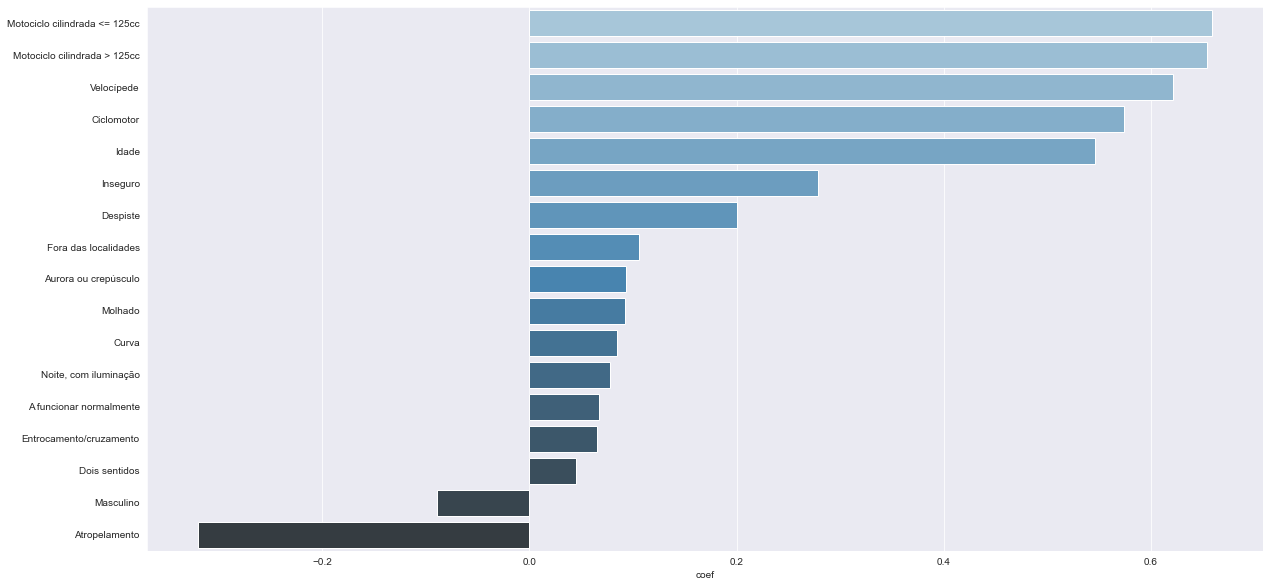

In [239]:
plt.figure(figsize = (20, 10))
sns.barplot(data = model_coef, y = model_coef.index, x = 'coef', palette="Blues_d")

Main points:
* The indicator that has a greater impact on a driver/passenger wounding is if he is on a two wheels vehicle;
* On the other hand the one that has the larger negative impact is if the driver hits a pedestrian;